# Assignment 1





In [1]:
try:
    from google.colab import files
    print("Upload 'Global finance data.csv' file")
    uploaded = files.upload()
    fname = list(uploaded.keys())[0]
except Exception as e:
    print("If not uploading manually, set fname to an existing path.")
    fname = "Global finance data.csv"


Upload 'Global finance data.csv' file


Saving Global finance data.csv to Global finance data.csv


In [2]:

import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load
df = pd.read_csv(fname)
target = "Banking_Sector_Health"

# Parse types
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in df.columns if c not in cat_cols]

# Date features (optional)
if "Date" in df.columns:
    try:
        df["Date"] = pd.to_datetime(df["Date"])
        df["Year"] = df["Date"].dt.year
        df["Month"] = df["Date"].dt.month
        if "Date" in cat_cols:
            cat_cols.remove("Date")
        if "Year" not in num_cols: num_cols.append("Year")
        if "Month" not in num_cols: num_cols.append("Month")
    except:
        pass

X = df.drop(columns=[target])
y = df[target]

cat_X = [c for c in cat_cols if c in X.columns]
num_X = [c for c in num_cols if c in X.columns]

preprocess = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_X),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown='ignore'))]), cat_X),
])

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=300),
    "KNN": KNeighborsClassifier(n_neighbors=5, weights="distance")
}

splits = [(0.4,0.6),(0.3,0.7),(0.25,0.75),(0.2,0.8),(0.15,0.85)]
records = []
cms = {}
rng=42

for algo, model in models.items():
    best_f1=-1; best_cm=None
    for i,(test_size, train_size) in enumerate(splits, start=1):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=rng+i, stratify=y
        )
        pipe = Pipeline([("prep", preprocess), ("model", model)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
        rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

        records.append({
            "Algorithm": algo, "Iteration": i,
            "Num_features": len(num_X)+len(cat_X),
            "Num_targets": y.nunique(),
            "Train_size_%": round(train_size*100,2),
            "Test_size_%": round(test_size*100,2),
            "Accuracy": round(acc,4),
            "Precision_macro": round(prec,4),
            "Recall_macro": round(rec,4),
            "F1_macro": round(f1,4),
        })
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
        if f1>best_f1: best_f1=f1; best_cm=cm
    cms[algo]=best_cm

table1 = pd.DataFrame(records)
table1.to_csv("Table1_classification_results.csv", index=False)
table1


,Algorithm,Iteration,Num_features,Num_targets,Train_size_%,Test_size_%,Accuracy,Precision_macro,Recall_macro,F1_macro
0,Decision Tree,1,26,3,60.0,40.0,0.9375,0.9524,0.9524,0.9487
1,Decision Tree,2,26,3,70.0,30.0,0.5833,0.6167,0.5833,0.5786
2,Decision Tree,3,26,3,75.0,25.0,0.8000,0.9048,0.7222,0.7667
3,Decision Tree,4,26,3,80.0,20.0,0.8750,0.8333,0.9167,0.8413
4,Decision Tree,5,26,3,85.0,15.0,1.0000,1.0000,1.0000,1.0000
5,Random Forest,1,26,3,60.0,40.0,0.9375,0.9583,0.8889,0.9111
6,Random Forest,2,26,3,70.0,30.0,0.8333,0.9167,0.7500,0.7937
7,Random Forest,3,26,3,75.0,25.0,0.8000,0.9048,0.7222,0.7667
8,Random Forest,4,26,3,80.0,20.0,0.8750,0.6000,0.6667,0.6296
9,Random Forest,5,26,3,85.0,15.0,0.6667,0.5333,0.5000,0.4722


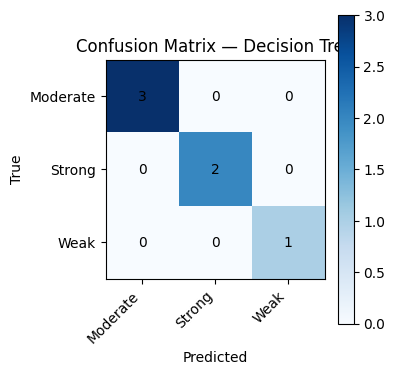

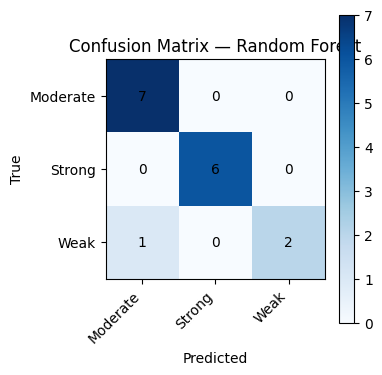

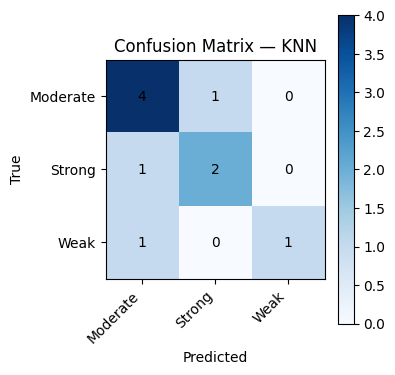

In [3]:

import matplotlib.pyplot as plt
import numpy as np

labels = np.unique(y)
for algo, cm in cms.items():
    if cm is None:
        continue
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(f"Confusion Matrix — {algo}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
